# Normalization of namespace

The goal is to prepare a `schema.org` document for context extraction using SPARQL or any other technique expecting URIs to be in a target namespace.

A challenge for processing `schema.org` content is variation in namespace use with both `https://schema.org/` and `http://schema.org/` being in common use. Typical patterns can be:

Setting the document default vocabulary to `https://schema.org/`:
```
{
    "@context": {
        "@vocab": "https://schema.org",
    },
    ...
}
```

Including a remote reference to the `schema.org` context:

```
{
    "@context": "http://schema.org",
    ...
}
```

Note that through a combination of redirection and HTTP link headers, any of the following remote context references result in the same document being retrieved by a JSON-LD processor:
```
http://schema.org
http://schema.org/
https://schema.org
https://shema.org/
http://schema.org/docs/jsonldcontext.jsonld
https://schema.org/docs/jsonldcontext.jsonld
```

The following provides one mechanism for normalizing JSON-LD that is known to be using `schema.org` to consistently use the namepsace prefix of `http://schema.org/`


In [1]:
import iplantuml

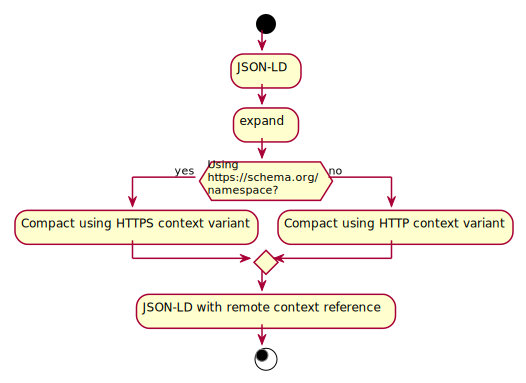

In [2]:
%%plantuml

@startuml
start
:JSON-LD;
:expand;
if (Using\nhttps://schema.org/\nnamespace?) then (yes)
  :Compact using HTTPS context variant;
else (no)
  :Compact using HTTP context variant;
endif
:JSON-LD with remote context reference;
stop
@enduml

In [3]:
import logging
import json
import pyld

logging.basicConfig(level=logging.INFO)
L = logging.getLogger("")

def pj(d):
    '''Print JSON to stdout
    '''
    print(json.dumps(d, indent=2))
    

# Map schema.org context URLs to local copy of original context
# Namespace = http://schema.org/
SO_CONTEXT = {
    "http://schema.org": "data/jsonldcontext.jsonld",
    "http://schema.org/": "data/jsonldcontext.jsonld",
    "https://schema.org": "data/jsonldcontext.jsonld",
    "https://schema.org/": "data/jsonldcontext.jsonld",
    "http://schema.org/docs/jsonldcontext.jsonld": "data/jsonldcontext.jsonld",
    "https://schema.org/docs/jsonldcontext.jsonld": "data/jsonldcontext.jsonld",
}

# Map schema.org context URLs to local copy of context
# with creator element adjusted to use an @list container
# Namespace = http://schema.org/
SOL_CONTEXT = {
    "http://schema.org": "data/jsonldcontext_l.jsonld",
    "http://schema.org/": "data/jsonldcontext_l.jsonld",
    "https://schema.org": "data/jsonldcontext_l.jsonld",
    "https://schema.org/": "data/jsonldcontext_l.jsonld",
    "http://schema.org/docs/jsonldcontext.jsonld": "data/jsonldcontext_l.jsonld",
    "https://schema.org/docs/jsonldcontext.jsonld": "data/jsonldcontext_l.jsonld",
}

# Map schema.org context URLs to local copy of context
# with https namespace
# Namespace = https://schema.org/
SOS_CONTEXT = {
    "http://schema.org": "data/jsonldcontext_s.jsonld",
    "http://schema.org/": "data/jsonldcontext_s.jsonld",
    "https://schema.org": "data/jsonldcontext_s.jsonld",
    "https://schema.org/": "data/jsonldcontext_s.jsonld",
    "http://schema.org/docs/jsonldcontext.jsonld": "data/jsonldcontext_s.jsonld",
    "https://schema.org/docs/jsonldcontext.jsonld": "data/jsonldcontext_s.jsonld",
}


def localDocumentLoader(context_map={}):
    '''Return a pyld.jsonld document loader.
    
    The document loader intercepts requests to retrieve a remote context
    and replaces with a local copy of the document.
    
    Args:
        context_map (dict): map of context URL to local document
      
    Returns:
        dict: 
    '''

    def localDocumentLoaderImpl(url, options={}):
        _url = url.lower().strip()
        doc = context_map.get(_url, None)
        if not doc is None:
            L.info("Loading local document for %s", _url)
            res = {
                "contextUrl": None,
                "documentUrl": "https://schema.org/docs/jsonldcontext.jsonld",
                "contentType": "application/ld+json",
                "document": json.load(open(doc, "r")),
            }
            return res
        # No mapping available, fall back to using the requests loader
        loader = pyld.jsonld.requests_document_loader()
        return loader(url)
    
    return localDocumentLoaderImpl
    

def isHttps(exp_doc) -> bool:
    """True if exp_doc is using https://schema.org/ namespace
    
    Returns the first match of the use of https://schema.org or
    http://schema.org on a key found by recursing through the
    object. 
    
    Args:
        exp_doc: expanded JSON-LD document
        
    Returns:
        bool: True is document is using `https://schema.org` namespace
    """
    for i,v in enumerate(exp_doc):
        if isinstance(v, dict):
            return isHttps(exp_doc[i])
        if isinstance(v, str):
            if v.startswith("https://schema.org"):
                return True
            elif v.startswith("http://schema.org"):
                return False
    return False


def switchToHttp(doc):
    """Convert SO JSONLD from https://schema.org/ to http://schema.org/
    
    The document is expanded and compacted with only schema.org properties
    compacted. Properties in other namespaces remain expanded.
    
    Args:
        doc: schema.org JSON-LD document
        
    Returns:
        document: JSON-LD document using http://schema.org/ namespace
    """
    # First expand the document
    expanded = pyld.jsonld.expand(doc)
    
    # Determine which context to apply
    is_https = isHttps(expanded)
    context_map = SO_CONTEXT
    if is_https:
        context_map = SOS_CONTEXT    
    options = {
        "documentLoader": localDocumentLoader(context_map=context_map),
    }

    # Compact the schema.org elements of the document
    context = {"@context":"https://schema.org/"}
    return pyld.jsonld.compact(expanded, context, options)


def addListContainer(doc):
    """Expand document with context including @list container for creator

    Args:
        doc: Schema.org document using http://schema.org/ namespace
    
    Returns:
        document: Expanded JSON-LD
    """
    options = {
        "documentLoader": localDocumentLoader(context_map=SOL_CONTEXT),
    }
    expanded = pyld.jsonld.expand(doc, options)
    return expanded


Load a JSON-LD document and print out the expanded form:

In [4]:
with open("data/test_00.jsonld") as inf:
    doc_s = json.load(inf)
pj(pyld.jsonld.expand(doc_s))

[
  {
    "@type": [
      "https://schema.org/Dataset"
    ],
    "https://schema.org/creator": [
      {
        "@type": [
          "https://schema.org/Person"
        ],
        "https://schema.org/name": [
          {
            "@value": "creator_03"
          }
        ]
      },
      {
        "@type": [
          "https://schema.org/Person"
        ],
        "https://schema.org/name": [
          {
            "@value": "creator_02"
          }
        ]
      },
      {
        "@type": [
          "https://schema.org/Person"
        ],
        "https://schema.org/name": [
          {
            "@value": "creator_01"
          }
        ]
      }
    ],
    "https://schema.org/description": [
      {
        "@value": "No remote context, vocab https://schema.org/, creator 03, 02, 01"
      }
    ]
  }
]


Convert the document to use the `http://schema.org/` namespace:

In [5]:
doc = switchToHttp(doc_s)
pj(pyld.jsonld.expand(doc))

INFO:root:Loading local document for https://schema.org/


[
  {
    "http://schema.org/creator": [
      {
        "http://schema.org/name": [
          {
            "@value": "creator_03"
          }
        ],
        "@type": [
          "http://schema.org/Person"
        ]
      },
      {
        "http://schema.org/name": [
          {
            "@value": "creator_02"
          }
        ],
        "@type": [
          "http://schema.org/Person"
        ]
      },
      {
        "http://schema.org/name": [
          {
            "@value": "creator_01"
          }
        ],
        "@type": [
          "http://schema.org/Person"
        ]
      }
    ],
    "http://schema.org/description": [
      {
        "@value": "No remote context, vocab https://schema.org/, creator 03, 02, 01"
      }
    ],
    "@type": [
      "http://schema.org/Dataset"
    ]
  }
]


In [27]:
context = {
    "@context": [
        "https://schema.org/",
        {
            "@vocab": "http://a.schema.org/",
            "so":"http://schema.org/",
            "creator": {
                "@id": "so:creator",
                "@container": "@list"
             }
        }
    ]
}
options = {
    "documentLoader": localDocumentLoader(context_map=SO_CONTEXT),
    "expandContext": context,
}

pj(pyld.jsonld.expand(doc, options))


INFO:root:Loading local document for https://schema.org/


[
  {
    "http://schema.org/creator": [
      {
        "http://schema.org/name": [
          {
            "@value": "creator_03"
          }
        ],
        "@type": [
          "http://schema.org/Person"
        ]
      },
      {
        "http://schema.org/name": [
          {
            "@value": "creator_02"
          }
        ],
        "@type": [
          "http://schema.org/Person"
        ]
      },
      {
        "http://schema.org/name": [
          {
            "@value": "creator_01"
          }
        ],
        "@type": [
          "http://schema.org/Person"
        ]
      }
    ],
    "http://schema.org/description": [
      {
        "@value": "No remote context, vocab https://schema.org/, creator 03, 02, 01"
      }
    ],
    "@type": [
      "http://schema.org/Dataset"
    ]
  }
]


Expand the document using a context that sets the container for `creator` to `@list`

In [6]:
doc_l = addListContainer(doc)
pj(doc_l)

INFO:root:Loading local document for https://schema.org/


[
  {
    "http://schema.org/creator": [
      {
        "@list": [
          {
            "http://schema.org/name": [
              {
                "@value": "creator_03"
              }
            ],
            "@type": [
              "http://schema.org/Person"
            ]
          },
          {
            "http://schema.org/name": [
              {
                "@value": "creator_02"
              }
            ],
            "@type": [
              "http://schema.org/Person"
            ]
          },
          {
            "http://schema.org/name": [
              {
                "@value": "creator_01"
              }
            ],
            "@type": [
              "http://schema.org/Person"
            ]
          }
        ]
      }
    ],
    "http://schema.org/description": [
      {
        "@value": "No remote context, vocab https://schema.org/, creator 03, 02, 01"
      }
    ],
    "@type": [
      "http://schema.org/Dataset"
    ]
  }
]


Same document output in N-Quads

In [13]:
options = {
    "algorithm": "URDNA2015",
    "format": "application/n-quads",
}
doc_nq = pyld.jsonld.normalize(doc_l, options)
print(doc_nq)

_:c14n0 <http://schema.org/name> "creator_01" .
_:c14n0 <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://schema.org/Person> .
_:c14n1 <http://schema.org/name> "creator_02" .
_:c14n1 <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://schema.org/Person> .
_:c14n2 <http://schema.org/name> "creator_03" .
_:c14n2 <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://schema.org/Person> .
_:c14n3 <http://www.w3.org/1999/02/22-rdf-syntax-ns#first> _:c14n1 .
_:c14n3 <http://www.w3.org/1999/02/22-rdf-syntax-ns#rest> _:c14n4 .
_:c14n4 <http://www.w3.org/1999/02/22-rdf-syntax-ns#first> _:c14n0 .
_:c14n4 <http://www.w3.org/1999/02/22-rdf-syntax-ns#rest> <http://www.w3.org/1999/02/22-rdf-syntax-ns#nil> .
_:c14n5 <http://schema.org/creator> _:c14n6 .
_:c14n5 <http://schema.org/description> "No remote context, vocab https://schema.org/, creator 03, 02, 01" .
_:c14n5 <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://schema.org/Dataset> .
_:c14n6 <http://www.w3.org/1999/02/22

In [17]:
import rdflib

def loadRDFDataset(doc):
    g = rdflib.Dataset()
    return g.parse(data=doc, format="nquads")

q_ordered = '''
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX SO:  <http://schema.org/>
SELECT (count(?mid)-1 as ?position) ?name 
WHERE {
  ?ds rdf:type SO:Dataset .
  ?ds SO:creator ?creatorlist .
  ?creatorlist rdf:rest* ?mid .
  ?mid rdf:rest* ?node .
  ?node rdf:first ?creator .
  ?creator SO:name ?name .
}
group by ?node ?creator
'''

#Load the document with the @list container
rdf_doc = loadRDFDataset(doc_nq)

results = rdf_doc.query(q_ordered)
for result in results:
    print(f"Entry: {result[0].value} = {result[1].value}")


Entry: 0 = creator_03
Entry: 1 = creator_02
Entry: 2 = creator_01
